In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
import pandas as pd
df=pd.read_csv('Dataset/healthcare.csv')

In [2]:
#As there are a lot of null data, i drop them.
df=df.dropna()

In [3]:
#Creating different dataframes for mortality and Incidence
Incidence_df=df[df['Type']=='Incidence']
Mortality_df=df[df['Type']=='Mortality']

In [4]:
#As i want to plot a summary, i need to sum all values by age
start_col = 'Age_0_to_4'
end_col = 'Age_85+'
start_idx = Incidence_df.columns.get_loc(start_col)
end_idx = Incidence_df.columns.get_loc(end_col)

selected_columns = Incidence_df.columns[start_idx:end_idx + 1]
Incidence_dict = Incidence_df[selected_columns].sum().to_dict()

selected_columns = Mortality_df.columns[start_idx:end_idx + 1]
Mortality_dict = Mortality_df[selected_columns].sum().to_dict()

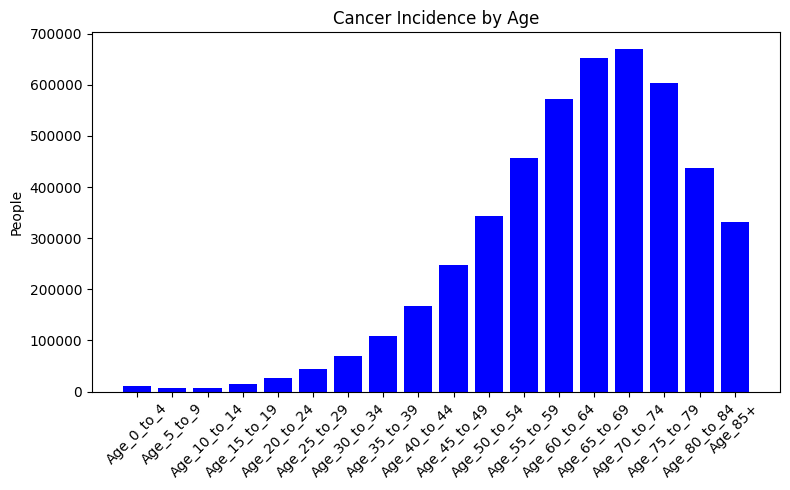

In [5]:
#Sum of incidence cases (for all cancers) by age
keys = list(Incidence_dict.keys())
values = list(Incidence_dict.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='blue')
plt.ylabel('People')
plt.title('Cancer Incidence by Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

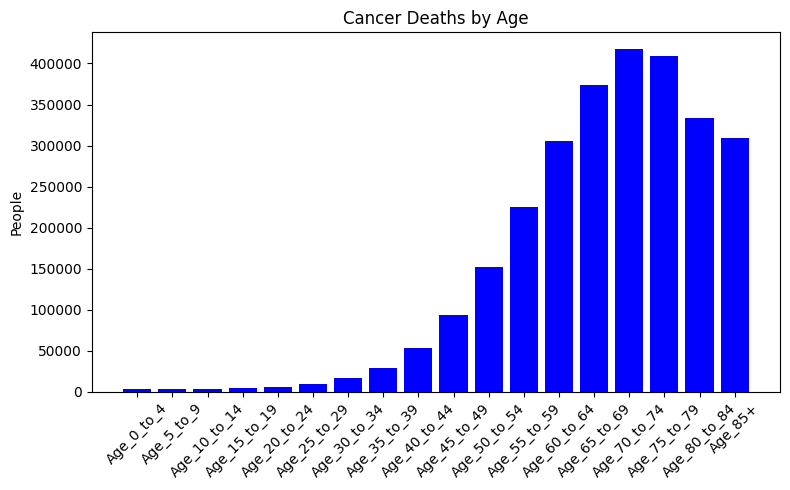

In [6]:
#Sum of all death (for all cancers) by age
keys = list(Mortality_dict.keys())
values = list(Mortality_dict.values())

plt.figure(figsize=(8, 5))
plt.bar(keys, values, color='blue')
plt.ylabel('People')
plt.title('Cancer Deaths by Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
filter = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Mortality") 
uterine_df1= df[filter]
uterine_df1=uterine_df1.dropna()

filter = (df["Cancer_Type"] == "Uterine cancer") & (df["Type"] == "Incidence") 
uterine_df2= df[filter]
uterine_df2=uterine_df2.dropna()

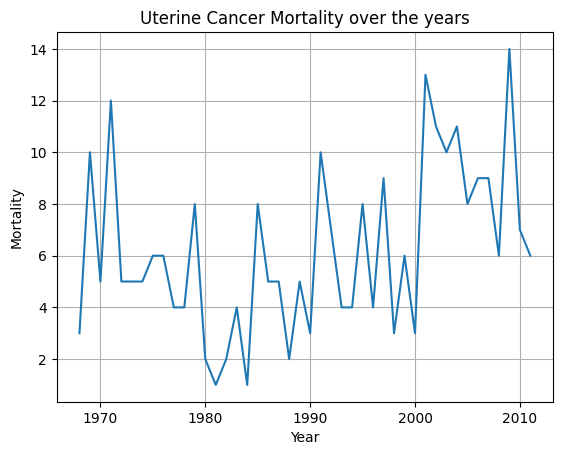

In [8]:
#Plot Uterine Cancer mortality for an example age
plt.plot(uterine_df1["Year"], uterine_df1['Age_45_to_49'])
plt.xlabel("Year")
plt.ylabel("Mortality")
plt.title("Uterine Cancer Mortality over the years")
plt.grid(True)
plt.show()

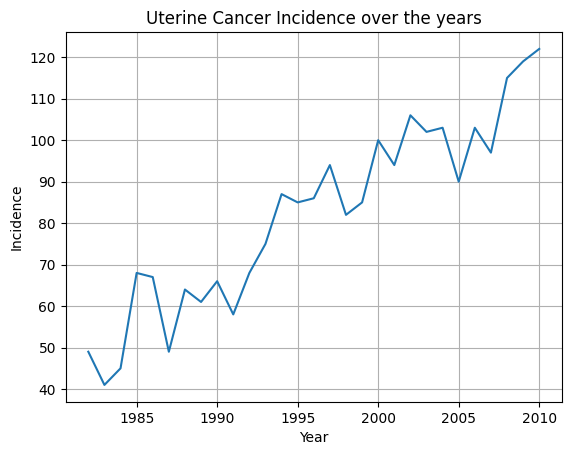

In [9]:
#Plot Uterine Cancer Incidence for an example age
plt.plot(uterine_df2["Year"], uterine_df2['Age_45_to_49'])
plt.xlabel("Year")
plt.ylabel("Incidence")
plt.title("Uterine Cancer Incidence over the years")
plt.grid(True)
plt.show()

In [10]:
#Now we want to evaluate incidence and mortality on the same graphic, so we need normalization. 
#I also sum cases for all ages
scaler=MinMaxScaler()

Mortality_df = Mortality_df.copy()
Incidence_df = Incidence_df.copy()
uterine_df1 = uterine_df1.copy()
uterine_df2 = uterine_df2.copy()

uterine_df1["Sum"] = uterine_df1.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df1['Normalized_sum']=scaler.fit_transform(uterine_df1[['Sum']])

uterine_df2["Sum_Death"] = uterine_df2.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
uterine_df2['Normalized_sum_death']=scaler.fit_transform(uterine_df2[['Sum_Death']])

Mortality_df["Sum_Death"] = Mortality_df.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)
Mortality_df['Normalized_sum_death']=scaler.fit_transform(Mortality_df[['Sum_Death']])

Incidence_df["Sum"] = Incidence_df.loc[:, "Age_0_to_4":"Age_Unknown"].sum(axis=1)

In [11]:
#Merging only for years that we have on both dataframe
uterine_df1 = pd.merge(uterine_df1, uterine_df2[['Year', 'Sum_Death', 'Normalized_sum_death']], on='Year', how='inner')

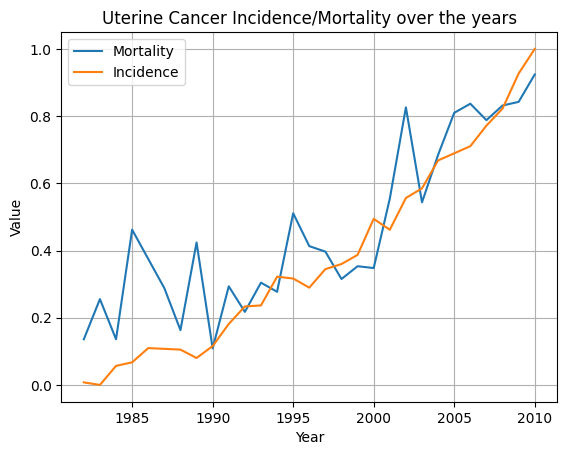

In [12]:
#Comparing normalized values for Incidence and Mortality of uterine cancer over the years
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum'], label="Mortality")
plt.plot(uterine_df1["Year"], uterine_df1['Normalized_sum_death'], label="Incidence")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Uterine Cancer Incidence/Mortality over the years")
plt.grid(True)
plt.show()


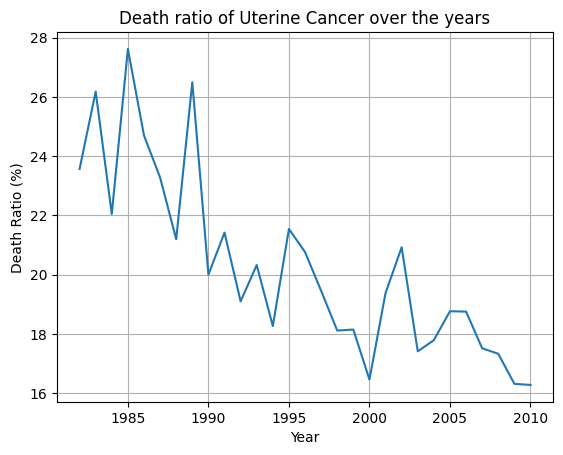

In [13]:
#Evaluating % values of death ratio of uterine cancer over the years
uterine_df1['Death_Ratio']=uterine_df1['Sum']/uterine_df1['Sum_Death']
plt.plot(uterine_df1['Year'], uterine_df1['Death_Ratio']*100 )
plt.xlabel('Year')
plt.ylabel('Death Ratio (%)')
plt.title('Death ratio of Uterine Cancer over the years')
plt.grid(True)
plt.show()

In [14]:
#Age groups clusterization. We'll make a long table using melt, then pivot to have value for every age across the years.

age_columns = uterine_df2.columns[4:] 

df_melted = uterine_df2.melt(
    id_vars=['Year', 'Sex', 'Type', 'Cancer_Type'],
    value_vars=age_columns,
    var_name='AgeGroup',
    value_name='Value'
)

In [15]:
df_age_matrix = df_melted.pivot_table(
    index='AgeGroup',
    columns=['Year', 'Sex', 'Type', "Cancer_Type"],
    values='Value',
    fill_value=0
)

In [16]:
#Values Standardization
scaler = StandardScaler()
Standardized_age_uterine= scaler.fit_transform(df_age_matrix)
Standardized_age_uterine = pd.DataFrame(Standardized_age_uterine, index=df_age_matrix.index, columns=df_age_matrix.columns.drop('Cluster', errors='ignore'))

In [17]:
#I don't need the last rows for this kind of work
Standardized_age_uterine = Standardized_age_uterine.drop(Standardized_age_uterine.index[[19,20]])

In [18]:
Standardized_age_uterine

Year,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,...,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
Sex,Female,Female,Female,Female,Female,Female,Female,Female,Female,Female,...,Female,Female,Female,Female,Female,Female,Female,Female,Female,Female
Type,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,...,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence,Incidence
Cancer_Type,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,...,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer,Uterine cancer
AgeGroup,,,,,,,,,,,,,,,,,,,,,
Age_0_to_4,-0.452751,-0.454179,-0.451424,-0.453806,-0.453386,-0.452322,-0.453460,-0.453543,-0.453943,-0.453290,...,-0.454767,-0.455666,-0.454937,-0.455306,-0.454932,-0.452354,-0.453579,-0.454976,-0.453740,-0.454301
Age_10_to_14,-0.452751,-0.454179,-0.451424,-0.453806,-0.453386,-0.452322,-0.453460,-0.453543,-0.453943,-0.453290,...,-0.454767,-0.455666,-0.454937,-0.455306,-0.454932,-0.454905,-0.453579,-0.454976,-0.453740,-0.454301
Age_15_to_19,-0.452751,-0.454179,-0.451424,-0.439805,-0.453386,-0.447900,-0.453460,-0.453543,-0.453943,-0.449229,...,-0.454767,-0.455666,-0.452137,-0.455306,-0.454932,-0.454905,-0.453579,-0.454976,-0.451533,-0.454301
Age_20_to_24,-0.437611,-0.449062,-0.446717,-0.449139,-0.448966,-0.447900,-0.453460,-0.453543,-0.445157,-0.453290,...,-0.454767,-0.455666,-0.446538,-0.450042,-0.449752,-0.454905,-0.451141,-0.450247,-0.453740,-0.454301
Age_25_to_29,-0.427518,-0.438828,-0.442010,-0.439805,-0.444546,-0.452322,-0.449015,-0.439780,-0.453943,-0.445168,...,-0.445484,-0.441326,-0.443739,-0.444778,-0.447162,-0.444701,-0.438950,-0.436060,-0.447118,-0.439497
Age_30_to_34,-0.366959,-0.408127,-0.442010,-0.421138,-0.409186,-0.416946,-0.440124,-0.412254,-0.423193,-0.428925,...,-0.417637,-0.424119,-0.435340,-0.418457,-0.416082,-0.416639,-0.421883,-0.395863,-0.411802,-0.428922


In [19]:
#Use KMeans to cluster ages using artifical Intelligence. The machine learning process identify ages with similar behavior.
#This is very useful in public health. 
kmeans = KMeans(n_clusters=4, random_state=42)
Standardized_age_uterine['Cluster'] = kmeans.fit_predict(Standardized_age_uterine)
df_clusters = Standardized_age_uterine.reset_index()[['AgeGroup', 'Cluster']].sort_values('Cluster')
df_clusters

Year,AgeGroup,Cluster
Sex,,
Type,,
Cancer_Type,,
7,Age_40_to_44,0
8,Age_45_to_49,0
17,Age_85+,0
16,Age_80_to_84,0
12,Age_60_to_64,1
14,Age_70_to_74,1
10,Age_55_to_59,1


In [20]:
# Supponiamo che 'df1' e 'df2' abbiano le colonne 'Year', 'AgeGroup', 'Gender', 'Region' come chiavi di merge
merged_df = pd.merge(Incidence_df, Mortality_df[['Year', 'Sex', 'Cancer_Type','Sum_Death']], on=['Year', 'Sex', 'Cancer_Type'], how='inner')
merged_df['Death_Ratio']=merged_df['Sum_Death']/merged_df['Sum']

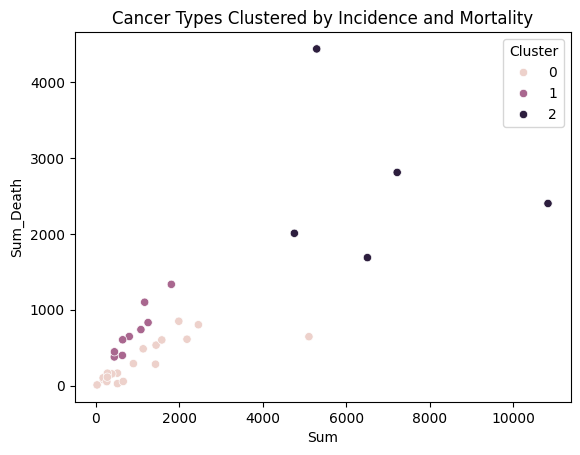

In [21]:
cancer_summary = merged_df.groupby('Cancer_Type').agg({
    'Sum': 'mean',
    'Sum_Death': 'mean',
    'Death_Ratio': 'mean'
}).reset_index()

features = ['Sum', 'Sum_Death', 'Death_Ratio']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer_summary[features])
kmeans = KMeans(n_clusters=3, random_state=42)
cancer_summary['Cluster'] = kmeans.fit_predict(X_scaled)

clustered_cancers = cancer_summary[['Cancer_Type', 'Cluster']].sort_values(by='Cluster')

sns.scatterplot(data=cancer_summary, x='Sum', y='Sum_Death', hue='Cluster')
plt.title("Cancer Types Clustered by Incidence and Mortality")
plt.show()

In [22]:
#It's important to rember that data can be influenced from past years, so it's possibile to have death rate higher than 1.
# On 10 new diagnosticad can die 11 (for example, 7 plus 4 giagnosticad the previous year). This is still relevant to evaluate death rate.

death_ratio_by_cancer = merged_df.groupby('Cancer_Type')['Death_Ratio'].mean().reset_index()
death_ratio_by_cancer = death_ratio_by_cancer.sort_values(by='Death_Ratio', ascending=False)

fig = px.bar(death_ratio_by_cancer, x='Cancer_Type', y='Death_Ratio',
             title='Death Ratio for every Cancer',
             labels={'Death_Ratio': 'Death Ratio', 'Cancer_Type': 'Cancer Type'},
             color='Death_Ratio',
             color_continuous_scale='reds', 
             text='Death_Ratio')  # 

fig.show()

In [23]:
cluster_0_df = cancer_summary[cancer_summary['Cluster'] == 1]
cluster_0_list = cluster_0_df['Cancer_Type'].tolist()

Cluster0_fulldf = merged_df[merged_df['Cancer_Type'].isin(cluster_0_list)]

In [24]:
Male_Mortality = pd.merge(Mortality_df, Incidence_df[['Year', 'Sex', 'Cancer_Type','Sum']], on=['Year', 'Sex', 'Cancer_Type'], how='inner')
Male_Mortality['Death_Ratio']=Male_Mortality['Sum_Death']/Male_Mortality['Sum']

Male_Mortality = Male_Mortality[
    (Male_Mortality['Type'] == 'Mortality') &
    (Male_Mortality['Sex'] == 'Male')
]

fig = px.line(Male_Mortality, x='Year', y='Death_Ratio', color='Cancer_Type',
              title='Death Ratio over the years for Male',
              labels={'Death_Ratio': 'Death Ratio', 'Year': 'Year'},
              markers=True)

cancer_types = Male_Mortality['Cancer_Type'].unique()

#interactive filter
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    args=[{'visible': [True] * len(cancer_types)}], 
                    label="All cancer types",
                    method="update"
                ),
                *[
                    dict(
                        args=[{'visible': [True if cancer == t else False for t in cancer_types]}, 
                              {'title': f'Death Ratio over the years {cancer}'}],
                        label=cancer,
                        method="update"
                    ) for cancer in cancer_types
                ]
            ],
            direction="down",  
            showactive=True,
            active=0,
            x=0.17, 
            xanchor="left",
            y=1.15,  
            yanchor="top"
        ),
    ]
)

fig.show()


In [25]:
Female_Mortality = pd.merge(Mortality_df, Incidence_df[['Year', 'Sex', 'Cancer_Type','Sum']], on=['Year', 'Sex', 'Cancer_Type'], how='inner')
Female_Mortality['Death_Ratio']=Female_Mortality['Sum_Death']/Female_Mortality['Sum']

Female_Mortality = Female_Mortality[
    (Female_Mortality['Type'] == 'Mortality') &
    (Female_Mortality['Sex'] == 'Female')  # oppure 'Male' / 'Female_Mortality'
]

fig = px.line(Female_Mortality, x='Year', y='Death_Ratio', color='Cancer_Type',
              title='Death Ratio over the years for female',
              labels={'Death_Ratio': 'Death Ratio', 'Year': 'Year'},
              markers=True)

cancer_types = Female_Mortality['Cancer_Type'].unique()

#interactive filter
fig.update_layout(
    updatemenus=[
        dict(
            buttons=[
                dict(
                    args=[{'visible': [True] * len(cancer_types)}], 
                    label="All cancer types",
                    method="update"
                ),
                *[
                    dict(
                        args=[{'visible': [True if cancer == t else False for t in cancer_types]}, 
                              {'title': f'Death Ratio over the years {cancer}'}],
                        label=cancer,
                        method="update"
                    ) for cancer in cancer_types
                ]
            ],
            direction="down",  
            showactive=True,
            active=0,
            x=0.17, 
            xanchor="left",
            y=1.15,  
            yanchor="top"
        ),
    ]
)

fig.show()


In [26]:
# Selezione delle features e target
X = Cluster0_fulldf[['Year','Age_5_to_9','Age_25_to_29','Age_60_to_64','Age_80_to_84']].values
y = Cluster0_fulldf['Death_Ratio'].values

# Normalizzazione delle features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalizzazione del target
scaler_target = StandardScaler()
y_scaled = scaler_target.fit_transform(y.reshape(-1, 1))

# Conversione in tensori
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1)

# Modello con architettura semplificata
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(5, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inizializzazione del modello, loss e optimizer
model = SimpleModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Allenamento
epochs = 500
for epoch in range(epochs):
    model.train()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Funzione di predizione
def predict_death_ratio(model, scaler, input_array):
    model.eval()
    input_scaled = scaler.transform([input_array])  # normalizza
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    with torch.no_grad():
        prediction = model(input_tensor)
    return prediction.item()

# Denormalizzazione della predizione
def denormalize_prediction(prediction, scaler_target):
    # Predizione è un float, quindi lo trasformiamo in un array 2D (1x1)
    return scaler_target.inverse_transform([[prediction]]).item()

# 🔮 Esempio di predizione
input_values = [2010, 0, 18, 1100, 1000]  # sostituisci con i tuoi valori
pred = predict_death_ratio(model, scaler, input_values)
pred_denorm = denormalize_prediction(pred, scaler_target)
print(f"Predicted Death Ratio: {pred_denorm:.2%}")  # output in percentuale



Epoch [50/500], Loss: 0.8852
Epoch [100/500], Loss: 0.8155
Epoch [150/500], Loss: 0.7431
Epoch [200/500], Loss: 0.7343
Epoch [250/500], Loss: 0.7098
Epoch [300/500], Loss: 0.6746
Epoch [350/500], Loss: 0.6465
Epoch [400/500], Loss: 0.5948
Epoch [450/500], Loss: 0.5313
Epoch [500/500], Loss: 0.5633
Predicted Death Ratio: 29.22%


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



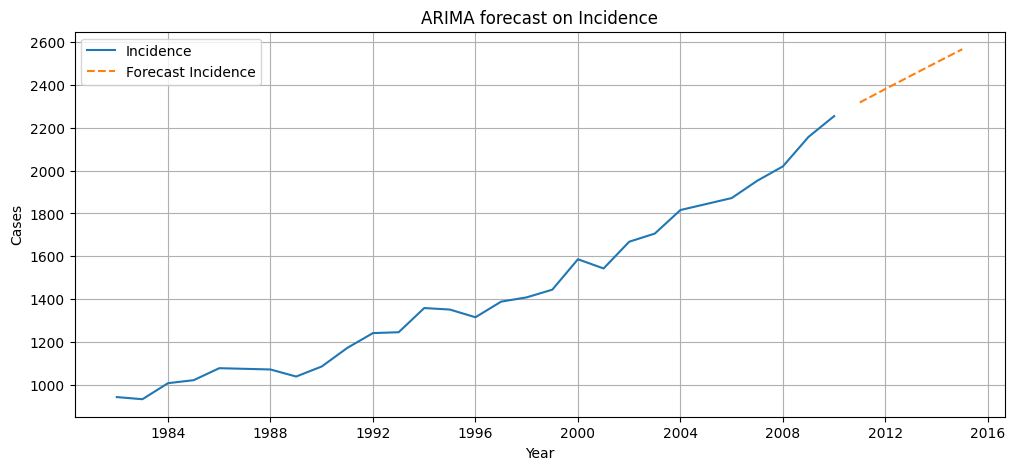

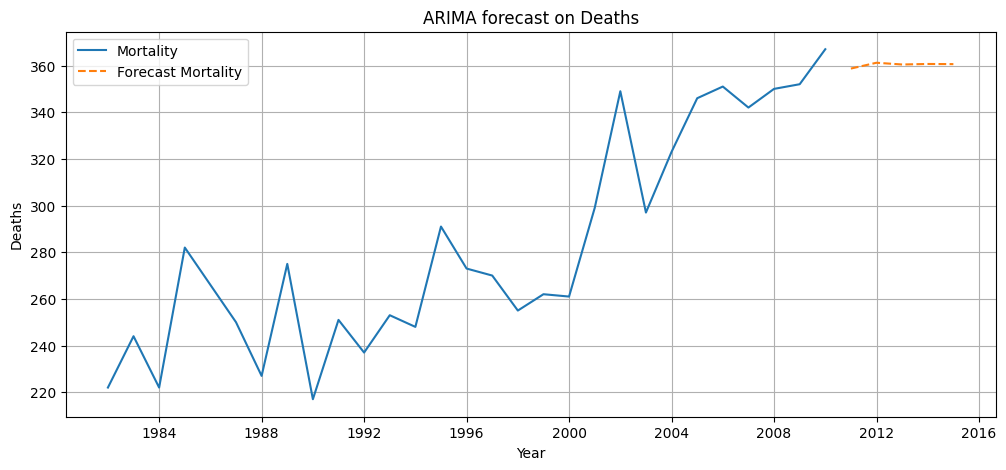

In [27]:
uterine_df1['Year'] = pd.to_datetime(uterine_df1['Year'], format='%Y')
uterine_df1.set_index('Year', inplace=True)
uterine_df1.index = uterine_df1.index.to_period('Y') 

# Temporal series
incidence_ts = uterine_df1['Sum_Death']
mortality_ts = uterine_df1['Sum']

# ARIMA Incidence
model_inc = ARIMA(incidence_ts, order=(1, 1, 1))
result_inc = model_inc.fit()
forecast_inc = result_inc.forecast(steps=5)

# ARIMA Mortality
model_mort = ARIMA(mortality_ts, order=(1, 1, 1))
result_mort = model_mort.fit()
forecast_mort = result_mort.forecast(steps=5)

# Convert index to timestamp
incidence_ts_plot = incidence_ts.copy()
incidence_ts_plot.index = incidence_ts_plot.index.to_timestamp()

forecast_inc_plot = forecast_inc.copy()
forecast_inc_plot.index = forecast_inc_plot.index.to_timestamp()

mortality_ts_plot = mortality_ts.copy()
mortality_ts_plot.index = mortality_ts_plot.index.to_timestamp()

forecast_mort_plot = forecast_mort.copy()
forecast_mort_plot.index = forecast_mort_plot.index.to_timestamp()

# Plot Incidence
plt.figure(figsize=(12, 5))
plt.plot(incidence_ts_plot, label='Incidence')
plt.plot(forecast_inc_plot, label='Forecast Incidence', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Cases")
plt.title('ARIMA forecast on Incidence')
plt.legend()
plt.grid(True)
plt.show()

# Plot Mortality
plt.figure(figsize=(12, 5))
plt.plot(mortality_ts_plot, label='Mortality')
plt.plot(forecast_mort_plot, label='Forecast Mortality', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Deaths")
plt.title('ARIMA forecast on Deaths')
plt.legend()
plt.grid(True)
plt.show()

#As it is completely normal to have non stationary warning on ARIMA, i ignore it

warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found")

In [28]:
Cluster0_fulldf = Cluster0_fulldf.copy()  # crea una vera copia
Cluster0_fulldf['Year'] = pd.to_datetime(Cluster0_fulldf['Year'], format='%Y')
Cluster0_fulldf.set_index('Year', inplace=True)
Cluster0_fulldf_grouped = Cluster0_fulldf.groupby(Cluster0_fulldf.index).agg({'Sum': 'sum'})

Epoch 10/200, Loss: 0.06707693636417389
Epoch 20/200, Loss: 0.0469784252345562
Epoch 30/200, Loss: 0.0333457887172699
Epoch 40/200, Loss: 0.027903685346245766
Epoch 50/200, Loss: 0.02288639359176159
Epoch 60/200, Loss: 0.014944372698664665
Epoch 70/200, Loss: 0.005586583167314529
Epoch 80/200, Loss: 0.0014282569754868746
Epoch 90/200, Loss: 0.0019344097236171365
Epoch 100/200, Loss: 0.0011949632316827774
Epoch 110/200, Loss: 0.0011865440756082535
Epoch 120/200, Loss: 0.0010179829550907016
Epoch 130/200, Loss: 0.0009405208984389901
Epoch 140/200, Loss: 0.0008483880083076656
Epoch 150/200, Loss: 0.000772313040215522
Epoch 160/200, Loss: 0.0006988152745179832
Epoch 170/200, Loss: 0.000632754061371088
Epoch 180/200, Loss: 0.0005728669930249453
Epoch 190/200, Loss: 0.0005198594299145043
Epoch 200/200, Loss: 0.00047385579091496766


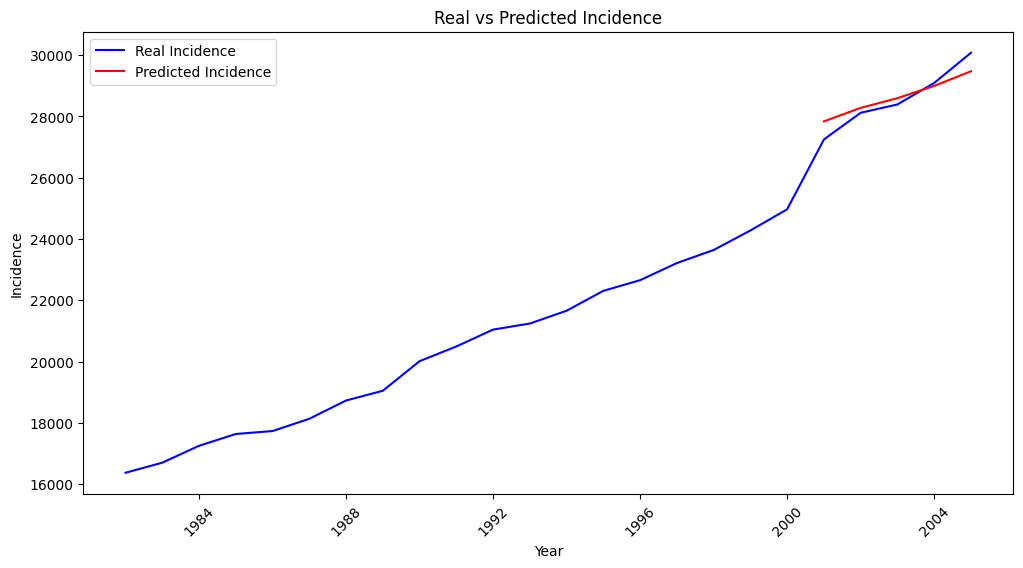


Next Incidence prediction:
Incidence=29977.85


In [29]:
def create_sequence(df, window_size):
    X, y = [], []
    for i in range(window_size, len(df)):
        X.append(df[i-window_size:i, :])  # dati precedenti, finestra
        y.append(df[i, :])  # valore futuro
    return np.array(X), np.array(y)

data = Cluster0_fulldf_grouped[['Sum']].values
dates = Cluster0_fulldf_grouped.index  # Usa l'indice del DataFrame come le date reali

# Data Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Parameters
window_size = 5
X, y = create_sequence(data_scaled, window_size)

# Split training from test (80% training, 20% test)
train_size = int(len(X) * 0.8)  # 80%  training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Conversion to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) 
        return out

input_size = 1  
hidden_layer_size = 64
output_size = 1 
model = LSTMModel(input_size, hidden_layer_size, output_size)

# Loss and optimization
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Prediction
model.eval()
with torch.no_grad():
    predictions = model(X_test)

# Back to prices
predictions = scaler.inverse_transform(predictions.numpy().reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# DF's index as date
test_dates = dates[train_size:train_size+len(y_test)] 

# Prediction DF
predicted_df = pd.DataFrame(predictions, index=test_dates, columns=['Predicted_Sum'])

real_data = np.concatenate((data[:train_size], y_test), axis=0)  
real_dates = np.concatenate((dates[:train_size], test_dates), axis=0)  
predicted_data = np.concatenate((real_data, predictions), axis=0)

# Plotting
plt.figure(figsize=(12, 6))

# MSCI real data
plt.plot(real_dates, real_data[:, 0], label='Real Incidence', color='blue')  

# Plotting previsions
plt.plot(predicted_df.index, predicted_df['Predicted_Sum'], label='Predicted Incidence', color='red') 
plt.title('Real vs Predicted Incidence')
plt.xlabel('Year')
plt.ylabel('Incidence')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Last price prediction
last_window = data_scaled[-window_size:]  
last_window = torch.tensor(last_window, dtype=torch.float32).unsqueeze(0)  # batch

model.eval()
with torch.no_grad():
    future_prediction = model(last_window)

future_prediction = scaler.inverse_transform(future_prediction.numpy())

# Next value prediction
print("\nNext Incidence prediction:")
print(f"Incidence={future_prediction[0][0]:.2f}")

